![LogoUC3M](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg/320px-Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg.png)

*GRUPO 21 | Alonso Rios Guerra - 100495821 | Guillermo Sancho González - 100495991 | GitHub: https://github.com/100495991/AA_practica2*



# *__Aprendizaje automático P2: Clustering de semillas__*

## *__1. Introducción__*

En esta práctica tenemos como objetivo desarrollar diferentes métodos de clustering sobre un conjunto de datos de semillas para comprobar si aparecen agrupaciones significativas en estos atributos, y qué técnica de clustering es la más efectiva en este caso.

Primero de todo empezaremos leyendo los datos proporcionados y los almacenamos en un DataFrame. Dividimos éstos datos en X (atributos de las semillas) e y (clase de las semillas).

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale
import numpy as np
import pandas as pd

data_path = 'semillas.csv'

seed = 1004959991

data = pd.read_csv(data_path, sep = ',')

X = data.drop(columns=['clase'])
y = data['clase']
target_names = sorted(y.unique().tolist())
"""
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
    ('scaler', scaler),  # Siempre escalar antes de PCA
    ('pca', PCA(random_state=seed))
    ])

    # Ajustar y transformar
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']

    # Varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 1. Plot de Varianza Explicada y Acumulada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

    # Añadir valores exactos
    for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
        plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
        plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')

    plt.xlabel('Componentes Principales')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza explicada por componente PCA')
    plt.legend(loc='best')
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    """

'\nfor scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):\n    pipeline = Pipeline([\n    (\'scaler\', scaler),  # Siempre escalar antes de PCA\n    (\'pca\', PCA(random_state=seed))\n    ])\n\n    # Ajustar y transformar\n    X_reduced = pipeline.fit_transform(X)\n    pca = pipeline.named_steps[\'pca\']\n\n    # Varianza explicada y acumulada\n    explained_variance = pca.explained_variance_ratio_\n    cumulative_variance = np.cumsum(explained_variance)\n\n    # 1. Plot de Varianza Explicada y Acumulada\n    plt.figure(figsize=(10, 6))\n    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label=\'Varianza individual\')\n    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where=\'mid\', label=\'Varianza acumulada\', color=\'red\')\n\n    # Añadir valores exactos\n    for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):\n        plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha=\'center\')\n        plt.text(i 

## *__2 . Principal Component Analysis__*

Se aplica PCA con 2 componentes, lo que hace una transformación no supervisada a 2 dimensiones, de tal manera que los datos puedan ser visualizados en 2D.

Para elegir el mejor Scaler se hace PCA con cada uno de ellos: StandardScaler, MinMaxScaler y RobustScaler para comprobar cual tiene mayor varianza explicada.

La varianza explicada representa cuánta varianza de los datos originales explican las dos componentes obtenidas tras aplicar PCA.
Cuanta mayor varianza explicada haya, menos información se perderá.

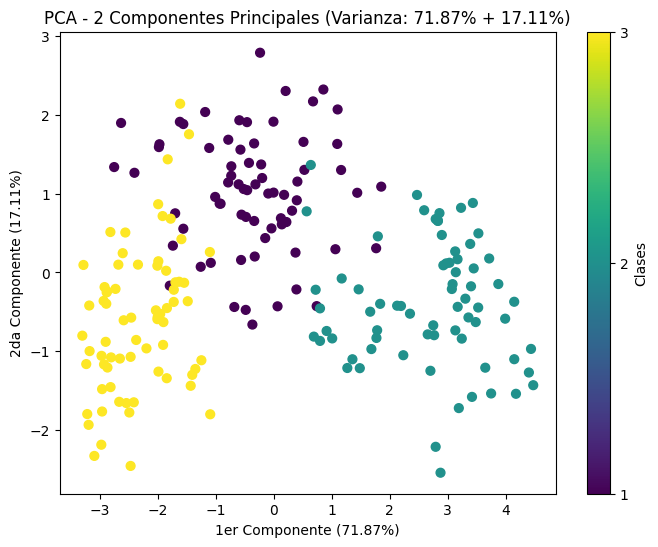

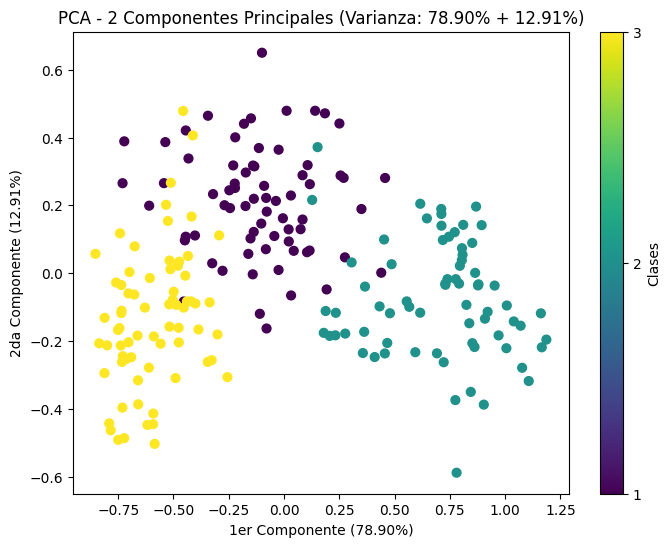

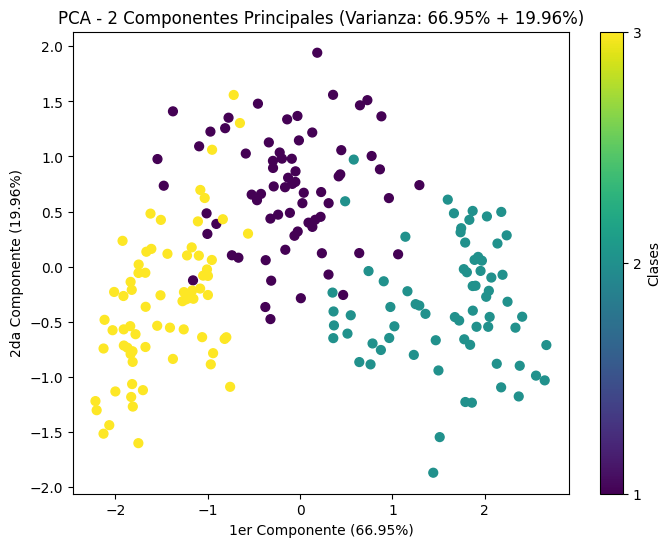

In [2]:
bestScaler = None
bestVariance = 0.0
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=seed))
    ])

    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=40, cmap='viridis')
    plt.title('PCA - 2 Componentes Principales (Varianza: {:.2%} + {:.2%})'.format(explained_variance[0], explained_variance[1]))
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    cbar = plt.colorbar(scatter, ticks=[1, 2, 3])
    cbar.set_label('Clases')
    plt.show()

    if sum(explained_variance) > bestVariance:
        bestVariance = sum(explained_variance)
        bestScaler = scaler

Observando estos gráficos se puede ver como el mejor Scaler para este modelo es el MinMaxScaler(), debido que obtienene la mayor varianza explicada total entre la suma de las dos componentes, 91.81%. Esto implica, en otras palabras, que es el que menos información pierde.

In [3]:
# Visualización 3D de PCA

"""
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
        ('scaler', scaler),  # Siempre escalar antes de PCA
        ('pca', PCA(n_components=3, random_state=seed))
    ])

    # Transformar
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']

    # Visualizar
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    scatter = ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        s=40,
        cmap='viridis',
    )

    ax.set(
        title="Primeras tres componentes PCA ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 + pca.explained_variance_ratio_[2]*100),
        xlabel="1er Componente ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),
        ylabel="2da Componente ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100),
        zlabel="3ra Componente ({:.2f}%)".format(pca.explained_variance_ratio_[2]*100)
    )

    # Leyenda
    legend1 = ax.legend(
        scatter.legend_elements()[0],
        target_names,
        loc="upper right",
        title="Clases"
    )
    ax.add_artist(legend1)

    plt.show()
"""

'\nfor scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):\n    pipeline = Pipeline([\n        (\'scaler\', scaler),  # Siempre escalar antes de PCA\n        (\'pca\', PCA(n_components=3, random_state=seed))\n    ])\n\n    # Transformar\n    X_reduced = pipeline.fit_transform(X)\n    pca = pipeline.named_steps[\'pca\']\n\n    # Visualizar\n    fig = plt.figure(figsize=(8, 6))\n    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)\n\n    scatter = ax.scatter(\n        X_reduced[:, 0],\n        X_reduced[:, 1],\n        X_reduced[:, 2],\n        c=y,\n        s=40,\n        cmap=\'viridis\',\n    )\n\n    ax.set(\n        title="Primeras tres componentes PCA ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 + pca.explained_variance_ratio_[2]*100),\n        xlabel="1er Componente ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),\n        ylabel="2da Componente ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100)

## *__3 . Seleccionar mejor técnica de clustering__*

Ya seleccionado el mejor scaler y haber transformado los datos a 2D, se aplicarán las técnicas de clustering explicadas en clase: K-Means, Hierarchical Clustering/Dendrogramas, DBSCAN


### *__3.1 . K-means__*

cluster,0,1,2,3,4,5
grupo_real,,,,,,
1,0,16,1,0,46,7
2,24,0,0,24,2,20
3,0,16,54,0,0,0


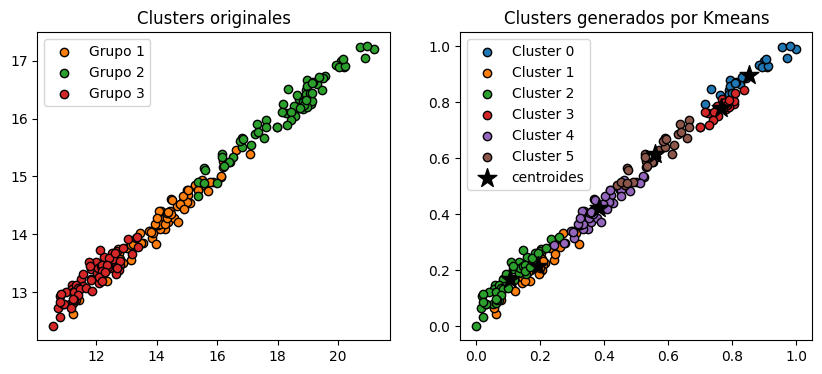

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

pipeline = Pipeline([
    ('scaler', bestScaler),  # Siempre escalar antes de PCA
    ('kmeans', KMeans(n_clusters=3, random_state=seed))
])

pipeline.fit(X)

y_predict = pipeline.predict(X)

X_scaled = pipeline.named_steps['scaler'].transform(X)

# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X.values[y == i, 0],
        y = X.values[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = pipeline.named_steps['kmeans'].cluster_centers_[:, 0],
    y = pipeline.named_steps['kmeans'].cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])